# Input pipeline

Во всех прошлых примерах мы считывали данные сразу в память компьютера. Т.к. мы работали с небольшими объемами, то это не было затруднительно. Но когда количество данных и их размер сильно увеличиваются и не помещаются в память -- нужны другие подходы.

Один из таких подходов, который часто применяется для работы с изображениями -- хранить данные на диске и считывать их с диска в память батчами в то время когда они становятся нужными. Для реализации такого подхода обязательно наличие быстрого диска (например SSD) иначе обучение может слишком затянуться. Одновременно со считыванием можно осуществялть операцию приведения к одному размеру, нормализации и т.д. Таким образом в памяти хранится только небольшая часть данных.

В этом уроке мы узнаем как реализовать такое поведение в Keras.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

2024-05-03 10:02:58.555877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-03 10:02:59.448663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Перед началом работы мы загрузим датасет. Он будет состоять из 2000 фотографий коше и собак в трейне и 1000 -- в тесте. Он может поместится в памяти, но мы намеренно будем работать с ним как с "большим".

In [13]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

После распаковки данные имеют следующую структуру:
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>


In [14]:
# определим папки с данными
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [15]:
num_cats_tr = len(list(train_cats_dir.glob("*"))) # .glob("*") создает итератор по всем файлам в директории
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [16]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [17]:
print(Path(zip_dir).parent / "cats_and_dogs_filtered")

/home/hik0/.keras/datasets/cats_and_dogs_filtered


(170, 211, 3)
(290, 349, 3)


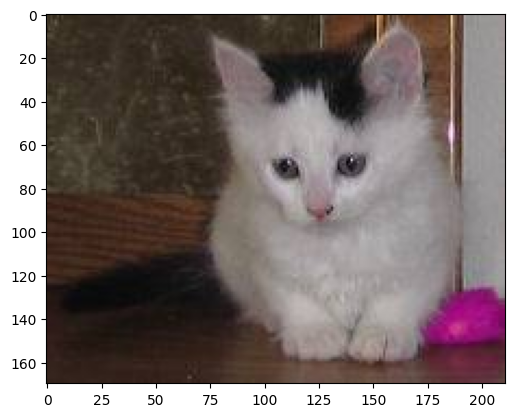

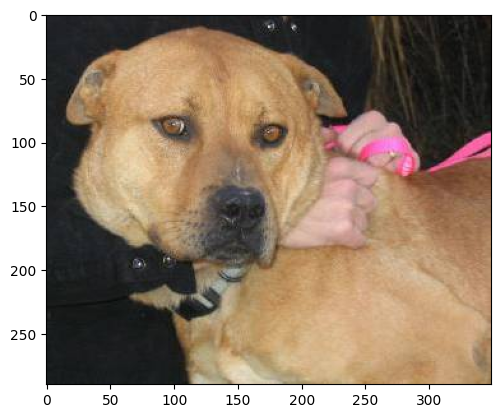

In [18]:
# взглянем на несколько картинок глазами

image_path = str(list(validation_cats_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

image_path = str(list(validation_dogs_dir.glob("*"))[0])
image = plt.imread(image_path)
plt.figure()
plt.imshow(image)
print(image.shape)

Обратите внимание на то, что картинки разных размеров. Для того чтобы нам упаковать их в входной тензор -- их нужно все привести к одному размеру.

Для дальнейшей работы мы должны реализовать код, который делает следующее:

1.  Считывает картинку с диска
2.  Приводит ее к заранее определенному размеру (IMAGE_SIZE, IMAGE_SIZE)
3.  Нормализует значения пикселей (делением на 255)
4.  Как только считано BATCH_SIZE картинок -- превратить их в четырехмерный тензор размера (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3) и подать на вход сети вместе с соотвествтующими им классами

In [19]:
BATCH_SIZE = 100 # размер батча -- т.е. количество картинок которые мы считываем за раз
                 # во многом зависит от доступной памяти GPU.
                 # Если ее не хватит (появится такая ошибка) значит нужно уменьшить размер батча или картинки
IMG_SHAPE  = 150

К счастью, в Keras это уже реализовано с помощью **ImageDataGenerator**

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
ImageDataGenerator?

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)
Docstring:      DEPRECATED.
File:           /mnt/500_gb/data_science/.venv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py
Type:           type
Subclasses:     

Как вы можете увидеть, у этого класса очень много параметров -- все они связаны с препроцессингом картинки. С некоторыми из них мы познакомимся позже.

Пока что нам интересен параметр *rescale*. От отвечает за нормализацию значений пикселей, а именно за умножение их на число -- в нашем случае 1./255.

Определив ImageDataGenerator мы сообщаем Keras что мы хотим сделать с картинкой после того как мы считали ее с диска.

Определим генераторы для трейна и валидации:

In [21]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

Теперь мы должны сообщить откуда и по сколько картинок мы хотим считывать. Для этого у ImageDataGenerator существует два метода: flow_from_directory и flow_from_dataframe. Первый ожидает определенную структуру папок из кторых он сам поймет к каким классам изображения относятся -- как в нашем случае. Второй работает с датафреймом где указаны пути до изображений и соответствующие им классы.

Т.к. наши данные уже в правильном виде -- воспользуемся для простоты первым подходом.

In [22]:
train_image_generator.flow_from_directory?

Signature:
train_image_generator.flow_from_directory(
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False,
)
Docstring: <no docstring>
File:      /mnt/500_gb/data_science/.venv/lib/python3.12/site-packages/keras/src/legacy/preprocessing/image.py
Type:      method



```
train_image_generator.flow_from_directory(directory, target_size=(256, 256),class_mode='categorical', batch_size=32, shuffle=True, ...)
```


*   directory -- путь до корневой папки в которой расположены папки с названиями классов и в которых лежат изоражения. Т.е. именно тот формат в котором мы имеем наши данные (см. схему выше). В нашем случае мы должны передать путь до папки train и validation для каждого из генераторов.
*   target_size -- размер к которому будут приведены все изображения
*   class_mode -- режим меток класса
--     categorical -- onehot encoded (например для двух классов класс 0 -- [1, 0], класс 1 -- [0, 1]
--     binary -- класс числом -- 1 или 0
--     sparse -- класс числом для не бинарного случая
--     input -- "класс" -- само изображение
--     None  -- без класса
*   batch_size -- размер батча
*   shuffle  -- перемешивать ли данные. Рекомендуется это делать во время трейна, чтобы батчи были разнообразные, но не делать во время теста -- чтобы сохранять порядок.




In [23]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir, # путь до папки train
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='binary') # т.к. у нас два класса можем воспользоваться binary

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir, # путь до папки validation
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Если директории в правильном формате, то  выше мы должны увидеть сообщение, что найдено 2000 картинок для двух классов.

In [24]:
# чтобы понять какой класс считается первым а какой вторым воспользуемся полем .class_indices
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

Взглянув на тип генератора, можно понять что это итератор. А значит мы можем итерироваться по нему с помощью next()

In [25]:
type(train_data_gen)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [26]:
sample_training_images, sample_labels = next(train_data_gen) # как только мы вополним эту команду, мы считаем 100 картинок с диска
                                                             # и преобразуем их к нужному формату

sample_training_images.shape, sample_labels.shape # 4x мерный тензор и вектор из меток класса

((100, 150, 150, 3), (100,))

In [27]:
sample_labels # т.к мы использовали shuffle --  в батче содержатся метки классов в случайном порядке

array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [28]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

Посмотрим на наши данные и увидим что они теперь все одного размера:

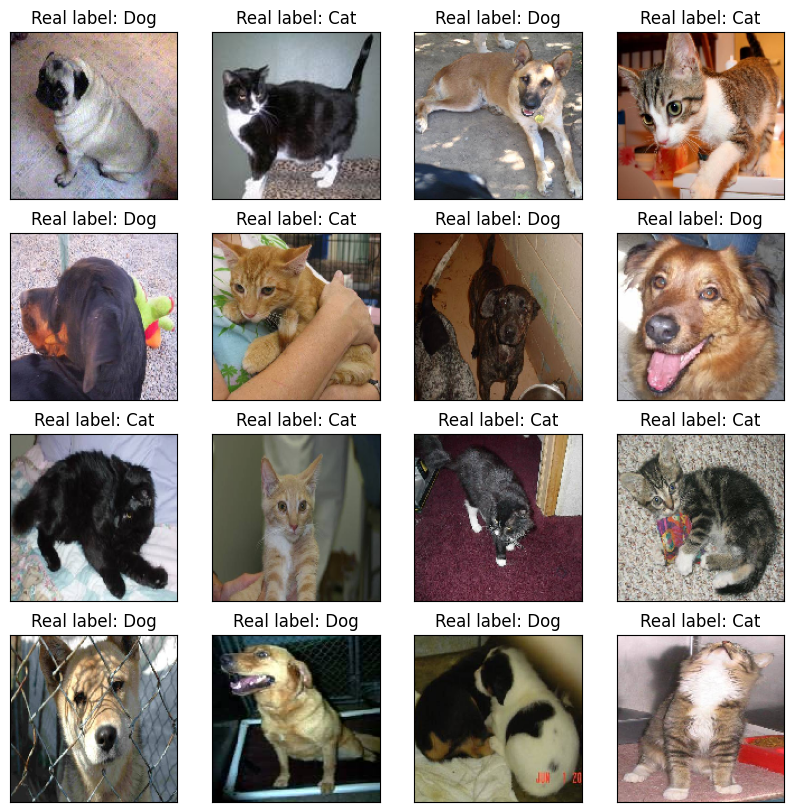

In [29]:
show_catsdogs(sample_training_images, sample_labels)
sample_training_images, sample_labels = next(train_data_gen)  # запустив эту клетку несколько раз картинки удут меняться

# Заключение
В этом уроке мы познакомились с тем как легко можно считать картинки и их лейблы с диска и подготовить для последующего обучения сети. Это далеко не единственный способ. Есть чуть более гибкие, но вместе с тем чуть более сложные подходы, которые мы пока не будем рассматривать. Рекомендую после практического задание, где мы обучим классификатор кошек и собак, которых мы научились считывать, ознакомится хотя бы бегло со следующими ссылками:
*   https://www.tensorflow.org/beta/tutorials/load_data/images
*   https://www.tensorflow.org/guide/performance/datasets
*   https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence